# 라이브러리 호출 및 데이터셋 호출

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# Computer Vision and utility libraries
import cv2
import copy

# Data handling
import tensorflow_datasets as tfds

# For image handling
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
슝=3


CAM과 Grad-CAM에 컴볼루션 레이어를 사용하기때문에 사전훈련된 ResNet의 가중치를 가져와서 학습시킨다.

In [4]:
num_classes = ds_info.features["label"].num_classes

# 1. ResNet50 모델 불러오기 (ImageNet 사전 학습된 가중치 사용)
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Fully connected layer 제거 (이미지넷 분류기 부분 제외)
    weights='imagenet',   # 사전 학습된 가중치 사용
    input_shape=(224, 224, 3),
    pooling=None         # 마지막 층에서 특성 맵을 그대로 유지하기 위해 None (CAM 추출용)
)

94781440/94765736 [==============================] - 0s 0us/step


In [5]:
# 2. Global Average Pooling (GAP) Layer 추가
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # 특성 맵을 평균 풀링으로 축소

# 3. 분류 레이어 추가 (softmax로 출력)
preds = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# 4. Grad-CAM 모델 정의
cam_model = keras.models.Model(inputs=base_model.input, outputs=preds)

In [6]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


In [7]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [8]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 161s 203ms/step - loss: 2.2625 - accuracy: 0.4299 - val_loss: 2.8072 - val_accuracy: 0.2965
Epoch 2/10
750/750 [==============================] - 157s 209ms/step - loss: 0.6970 - accuracy: 0.8109 - val_loss: 1.2888 - val_accuracy: 0.6256
Epoch 3/10
750/750 [==============================] - 157s 209ms/step - loss: 0.1830 - accuracy: 0.9703 - val_loss: 1.1281 - val_accuracy: 0.6811
Epoch 4/10
750/750 [==============================] - 156s 208ms/step - loss: 0.0590 - accuracy: 0.9966 - val_loss: 0.9772 - val_accuracy: 0.7225
Epoch 5/10
750/750 [==============================] - 156s 208ms/step - loss: 0.0473 - accuracy: 0.9977 - val_loss: 1.0867 - val_accuracy: 0.7001
Epoch 6/10
750/750 [==============================] - 157s 209ms/step - loss: 0.0184 - accuracy: 0.9994 - val_loss: 0.9614 - val_accuracy: 0.7332
Epoch 7/10
750/750 [==============================] - 157s 209ms/step - loss: 0.0181 - accuracy: 0.9987 - val_loss: 0.9718 -

원래 에폭은 20이였음, 하지만 매우 미세하게 오버피팅이 일어나는 것을 확인함(정량적으로 확인)

그래서 기존 20이 아닌 10으로 재학습진행

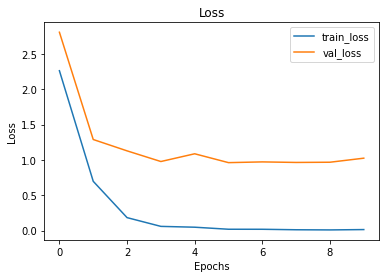

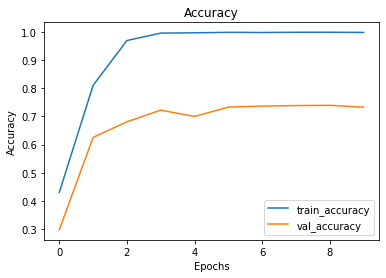

In [9]:
# 학습 손실 및 정확도 시각화 함수
def plot_history(history):
    # 학습 손실과 검증 손실을 시각화
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # 학습 정확도와 검증 정확도 시각화
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 기록 시각화
plot_history(history_cam_model)

# 루브릭 1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?
ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정을 시각화를 통해 나타냄

# 시각화

실제로 CAM과 Grad_CAM을 비교할 수 있도록 먼저 히트맵처럼 그린다음, 실제 이미지와 겹쳐서 확인한다.

116


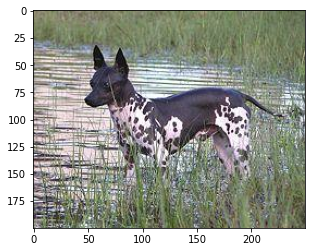

In [38]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()



In [11]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

print('슝=3')

슝=3


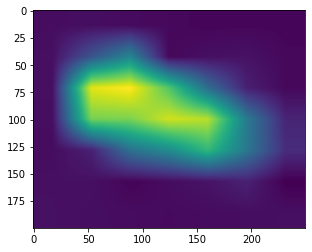

In [15]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [12]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝=3')

슝=3


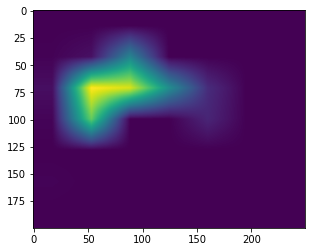

In [18]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

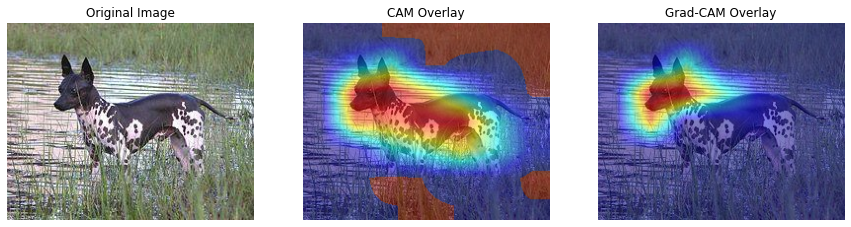

In [40]:
origin_image = item['image'].astype(np.uint8)

# 2. CAM 생성 함수
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

# 3. Grad-CAM 생성 함수
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        loss = pred[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]

    weights = np.mean(grad_val, axis=(0, 1))
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[1:3])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

# 4. 오버레이 이미지 합성 함수 (컬러맵 적용)
def visualize_cam_on_image(cam_image, origin_image, alpha=0.5):
    """
    CAM 히트맵에 컬러맵을 적용하고 원본 이미지에 오버레이
    """
    # CAM 이미지를 0~255로 변환하고 컬러맵 적용
    cam_image_colormap = cv2.applyColorMap(np.uint8(255 * cam_image), cv2.COLORMAP_JET)
    
    # OpenCV는 BGR로 반환하므로 RGB로 변환
    cam_image_colormap = cv2.cvtColor(cam_image_colormap, cv2.COLOR_BGR2RGB)
    
    # 원본 이미지와 오버레이
    beta = (1.0 - alpha)
    blended_image = cv2.addWeighted(cam_image_colormap, alpha, origin_image, beta, 0.0)
    
    return blended_image

# 5. CAM과 Grad-CAM 시각화
def visualize_all(model, item, activation_layer):
    # 원본 이미지
    origin_image = item['image'].astype(np.uint8)
    
    # CAM 생성 및 오버레이
    cam_image = generate_cam(model, item)
    cam_overlay = visualize_cam_on_image(cam_image, origin_image)
    
    # Grad-CAM 생성 및 오버레이
    grad_cam_image = generate_grad_cam(model, activation_layer, item)
    grad_cam_overlay = visualize_cam_on_image(grad_cam_image, origin_image)
    
    # 결과 시각화: 원본, CAM, Grad-CAM
    plt.figure(figsize=(15, 6))
    
    # 1. 원본 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(origin_image)
    plt.title("Original Image")
    plt.axis('off')
    
    # 2. CAM 이미지
    plt.subplot(1, 3, 2)
    plt.imshow(cam_overlay)
    plt.title("CAM Overlay")
    plt.axis('off')
    
    # 3. Grad-CAM 이미지
    plt.subplot(1, 3, 3)
    plt.imshow(grad_cam_overlay)
    plt.title("Grad-CAM Overlay")
    plt.axis('off')
    
    plt.show()


# CAM 및 Grad-CAM 시각화
visualize_all(cam_model, item, 'conv5_block3_out')

CAM과 Grad_CAM을 확인해봤을때, 둘다 강아지라고 인식이되지만,

우리가 배운것처럼 CAM은 좀 더 넓은 범위를 인식하지만, Grad_cam은 좀 더 자세한 얼굴부위를 인식하는 것을 알수있다.

# 루브릭 2.분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?
CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.

# 바운딩 박스, IOU 파트

In [13]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [43]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox


In [45]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('슝=3')

슝=3


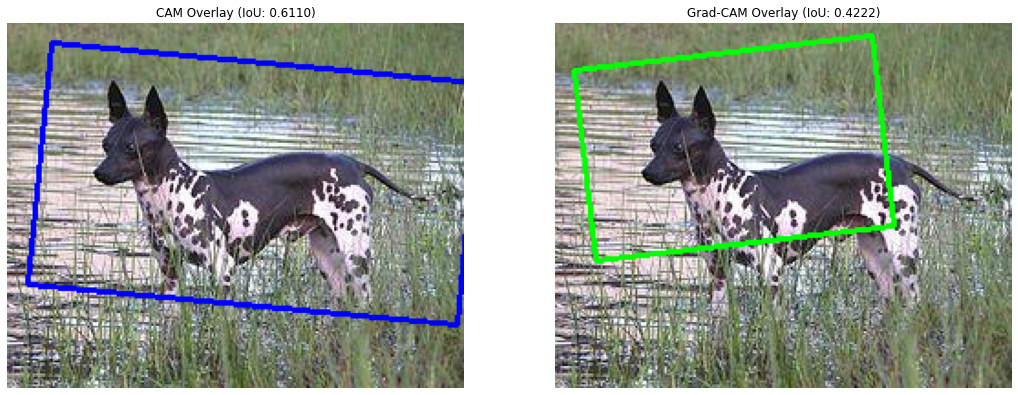

CAM IoU: 0.6110
Grad-CAM IoU: 0.4222


In [48]:
# CAM 및 Grad-CAM 시각화 및 IoU 계산
def compare_cam_gradcam(model, item, activation_layer):
    # 원본 이미지
    origin_image = item['image'].astype(np.uint8)
    
    # CAM 생성 및 Bounding Box 추출
    cam_image = generate_cam(model, item)
    cam_bbox = get_bbox(cam_image)
    cam_overlay = visualize_cam_on_image(cam_image, origin_image)
    
    # CAM Bounding Box 그리기
    cam_overlay_box = copy.deepcopy(origin_image)
    cam_overlay_box = cv2.drawContours(cam_overlay_box, [cam_bbox], 0, (0, 0, 255), 2)
    
    # CAM IoU 계산
    pred_cam_bbox = rect_to_minmax(cam_bbox, item['image'])
    true_bbox = item['objects']['bbox'][0]  # 실제 bounding box
    iou_cam = get_iou(pred_cam_bbox, true_bbox)
    
    # Grad-CAM 생성 및 Bounding Box 추출
    grad_cam_image = generate_grad_cam(model, activation_layer, item)
    grad_cam_bbox = get_bbox(grad_cam_image)
    grad_cam_overlay = visualize_cam_on_image(grad_cam_image, origin_image)
    
    # Grad-CAM Bounding Box 그리기
    grad_cam_overlay_box = copy.deepcopy(origin_image)
    grad_cam_overlay_box = cv2.drawContours(grad_cam_overlay_box, [grad_cam_bbox], 0, (0, 255, 0), 2)
    
    # Grad-CAM IoU 계산
    pred_grad_cam_bbox = rect_to_minmax(grad_cam_bbox, item['image'])
    iou_grad_cam = get_iou(pred_grad_cam_bbox, true_bbox)
    
    # 결과 시각화: CAM, Grad-CAM, Bounding Box
    plt.figure(figsize=(18, 8))
    
    # 1. CAM 오버레이 및 Bounding Box 시각화
    plt.subplot(1, 2, 1)
    plt.imshow(cam_overlay_box)
    plt.title(f"CAM Overlay (IoU: {iou_cam:.4f})")
    plt.axis('off')
    
    # 2. Grad-CAM 오버레이 및 Bounding Box 시각화
    plt.subplot(1, 2, 2)
    plt.imshow(grad_cam_overlay_box)
    plt.title(f"Grad-CAM Overlay (IoU: {iou_grad_cam:.4f})")
    plt.axis('off')
    
  
    
    plt.show()

    # IoU 결과 출력
    print(f"CAM IoU: {iou_cam:.4f}")
    print(f"Grad-CAM IoU: {iou_grad_cam:.4f}")

# 사용 예시
compare_cam_gradcam(cam_model, item, 'conv5_block3_out')

여기서 차이점이 좀 더 발견된거같다.

박스 자체는 CAM이 더 크게 잡혔다. 하지만, cam의 시각화를 보면 알 수 있듯이 히트맵 자체도 크기때문에 IOU가 0.5보다 크게 잡혔다.

하지만 Grad-cam의 경우 히트맵에비해 박스의 크기가 너무 크게 잡혀서 IOU가 작게 나온거같다.


---

# 여기까지